# Wrangle the Raster Data (3 layers)

In [1]:
# Download stored variables from previous notebook

%store -r habitat_suitability_data_dir usfs_grasslands_path comanche_grassland_gdf pawnee_grassland_gdf usfs_grasslands_gdf

In [2]:
# Prepare for download Part 1 of 1
## Import packages that will help with...

# Reproducible file paths
import os # Reproducible file paths
import pathlib # Find the home folder
from glob import glob  # returns list of paths
import zipfile # Work with zip files

# Find files by pattern
import matplotlib.pyplot as plt # Overlay pandas and xarry plots,Overlay raster and vector data
import rioxarray as rxr # Work with geospatial raster data


# Work with tabular, vector, and raster data
import cartopy.crs as ccrs # CRSs (Coordinate Reference Systems)
import geopandas as gpd # work with vector data
import hvplot.pandas # Interactive tabular and vector data
import hvplot.xarray # Interactive raster
from math import floor, ceil # working with bounds, floor rounds down ciel rounds up
import pandas as pd # Group and aggregate
from rioxarray.merge import merge_arrays # Merge rasters
import xarray as xr # Adjust images

# Access NASA data
import earthaccess # Access NASA data from the cloud

## 1. POLARIS dataset - download 2 soil variables

In [3]:
# Practice downloading soil data with random 1x1 tif
# Part 1 of 3
practice_soil_url = (
            "http://hydrology.cee.duke.edu"
            "/POLARIS/PROPERTIES/v1.0"
            "/ph"
            "/mean"
            "/60_100"
            "/lat2829_lon-101-100.tif"
            )

practice_soil_url

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat2829_lon-101-100.tif'

In [4]:
# Practice downloading soil data with random 1x1 tif
# Part 2 of 3

# Connect to raster image
practice_soil_da = rxr.open_rasterio(
    practice_soil_url,
    mask_and_scale=True
).squeeze()

practice_soil_da

<xarray.DataArray (y: 3600, x: 3600)> Size: 52MB
[12960000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB -101.0 -101.0 -101.0 ... -100.0 -100.0 -100.0
  * y            (y) float64 29kB 29.0 29.0 29.0 29.0 ... 28.0 28.0 28.0 28.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area

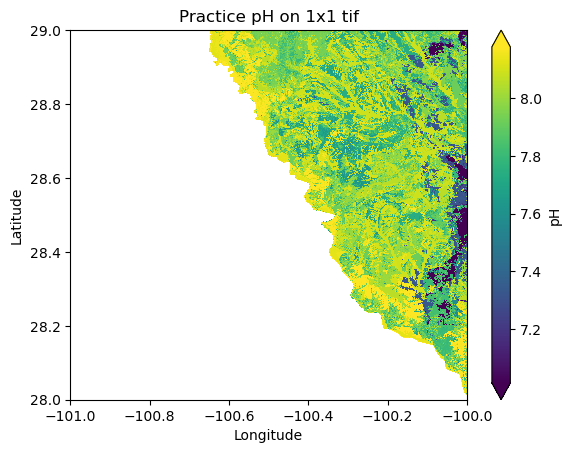

In [5]:
# Practice downloading soil data with random 1x1 tif
# Part 3 of 3

# Plot
practice_soil_da.plot(
    cbar_kwargs={"label": "pH"},
    robust=True
    )
plt.gca().set(
    title='Practice pH on 1x1 tif', 
    xlabel='Longitude',
    ylabel='Latitude',
)
plt.show()

<Axes: >

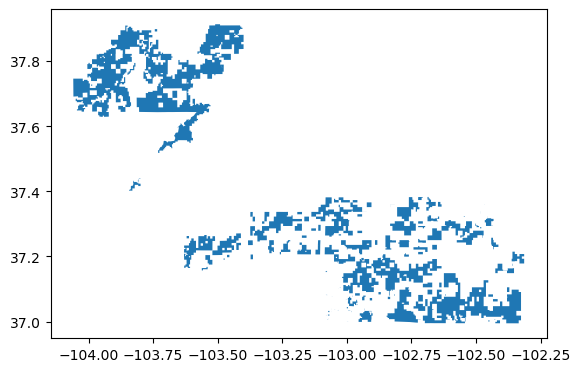

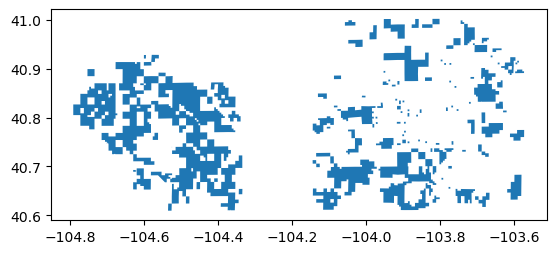

In [6]:
# Plot Comanche and Pawnee National Grasslands to see max and min
# latitudes and longitudes

comanche_grassland_gdf.plot()

pawnee_grassland_gdf.plot()

In [7]:
# Download soil data with all tifs that cover study areas
# Part 1 of 1
soil_url_template = (
            "http://hydrology.cee.duke.edu"
            "/POLARIS/PROPERTIES/v1.0"
            "/ph"
            "/mean"
            "/60_100"
            "/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
            )


soil_url_template

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif'

In [8]:
# practice for what is going in the function
bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
comanche_grassland_gdf.total_bounds
)

soil_url_list= []
for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
    for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
        formated_soil_url = (
            soil_url_template.format( 
            min_lat=min_lat , max_lat=min_lat+1,
            min_lon=min_lon, max_lon=min_lon+1 )
        )

        soil_url_list.append(formated_soil_url)

soil_url_list

['http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3637_lon-105-104.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3738_lon-105-104.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3637_lon-104-103.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3738_lon-104-103.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3637_lon-103-102.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat3738_lon-103-102.tif']

In [9]:
# Process Raster Image Part 1 of 1

# Create function with description to process raster images
def process_image(url, bounds_gdf):
    """
    Load, crop, and scale a raster image 

    Parameters
    ----------
    url: file-like or path-like
      File accessor downloaded or obtained 
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to

    Returns
    -------
    cropped_da: rxr.DataArray
      Processed raster
    """

    # Get the study bounds
    bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    bounds_gdf
    .to_crs(4326)
    .total_bounds 
    )
    da_list= []
    for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
      for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
        formated_url = (
          url.format( 
              min_lat=min_lat , max_lat=min_lat+1,
              min_lon=min_lon, max_lon=min_lon+1 )
        )

        # Connect to the raster image
        da = rxr.open_rasterio(
        formated_url, 
        mask_and_scale=True
        ).squeeze()
        
        # Crop 
        cropped_da = (
        da.rio.clip_box(bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat)
        )

        da_list.append(cropped_da)

    merged_da_list = (
    merge_arrays(da_list)
    )
    
    return merged_da_list



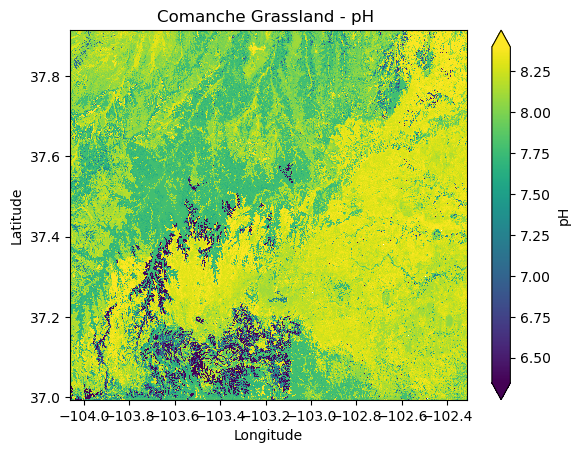

In [10]:
# Test the function
process_image(soil_url_template, comanche_grassland_gdf).plot(
    cbar_kwargs={"label": "pH"},
    robust=True,
)
plt.gca().set(
    title='Comanche Grassland - pH ',
    xlabel='Longitude', 
    ylabel='Latitude', 
)
plt.show()

## 2. Elevation Data using SRTM

In [11]:
# Prep for downloading SRTM 

# Create data dir 
elevation_dir= os.path.join(habitat_suitability_data_dir, 'srtm')

os.makedirs(elevation_dir, exist_ok=True)

# call the variable to check location
elevation_dir

'/Users/briannagleason/earth-analytics/data/habitat_suitability/srtm'

In [23]:
# Download Raster data through earthaccess Part 1 of 1

# login to earthaccess
earthaccess.login(strategy="interactive", persist=True)

# define bounds with tuple outside of conditional
bounds=tuple(comanche_grassland_gdf.total_bounds)

# Only download once - conditional
if not glob (os.path.join(elevation_dir, '*hgt.zip')):
   
# Search earthaccess
    elevation_results = earthaccess.search_data(
        short_name="SRTMGL1",
        bounding_box=bounds,
    )
    
elevation_results

# Open earthaccess results
srtm_file = earthaccess.download(elevation_results, elevation_dir)

QUEUEING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/6 [00:00<?, ?it/s]

In [24]:
# Check srtm_file by calling it
## Will need to test a certain tile in the next cell
## by using count of location in the list
srtm_file

['/Users/briannagleason/earth-analytics/data/habitat_suitability/srtm/N37W103.SRTMGL1.hgt.zip',
 '/Users/briannagleason/earth-analytics/data/habitat_suitability/srtm/N36W103.SRTMGL1.hgt.zip',
 '/Users/briannagleason/earth-analytics/data/habitat_suitability/srtm/N37W104.SRTMGL1.hgt.zip',
 '/Users/briannagleason/earth-analytics/data/habitat_suitability/srtm/N36W104.SRTMGL1.hgt.zip',
 '/Users/briannagleason/earth-analytics/data/habitat_suitability/srtm/N36W105.SRTMGL1.hgt.zip',
 '/Users/briannagleason/earth-analytics/data/habitat_suitability/srtm/N37W105.SRTMGL1.hgt.zip']

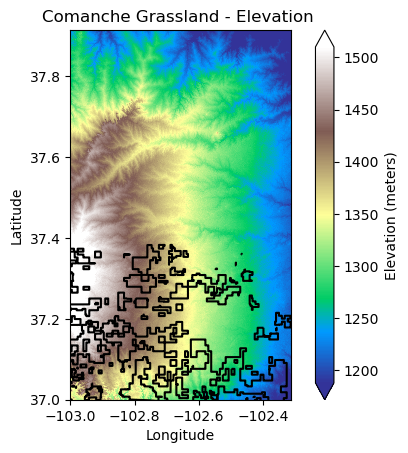

In [35]:
# Process data using the process_image function

# Test the function
process_image(srtm_file[0], comanche_grassland_gdf).plot(
    cbar_kwargs={"label": "Elevation (meters)"},
    robust=True,
    cmap='terrain',
)

comanche_grassland_gdf.boundary.plot(ax=plt.gca(),
    color='black').set(
        title='Comanche Grassland - Elevation ',
        xlabel='Longitude', 
        ylabel='Latitude', 
    )
plt.show()


In [ ]:
# Prep for processing raster data repeatedly

# Compile a regular expression to search for metadata
metadata_rows = re.compile(
 r"HLS\.L30\.(?P<tile_id>T[0-9A-Z]+)\.(?P<date>\d+)T\d+\.v2\.0\."
 r"(?P<band_id>.+)\.tif"   
)

# Find all the metadata in the file name
philadelphia_metadata_rows = [
    metadata_rows.search(philadelphia_file.full_name).groupdict()
    for philadelphia_file in philadelphia_files]

# Create a DataFrame with the metadata
philadelphia_raster_df = pd.DataFrame(philadelphia_metadata_rows)
# Add the File-like URI to the DataFrame
philadelphia_raster_df['file'] = philadelphia_files
# Check the results
philadelphia_raster_df

In [ ]:
# Process data using a for loop 

# Labels for each band to process - dictionary
philadelphia_bands = {
    'B02': 'blue',
    'B03': 'green',
    'B04': 'red',
    'B05': 'nir',
    'B06': 'swir1',
    'B07': 'swir2',
}
# Initialize structure for saving images
philadelphia_das = {band_name: [] for band_name in philadelphia_bands.values()}
for tile_id, tile_df in philadelphia_raster_df.groupby('tile_id'):

   # Load the cloud mask
   philadelphia_fmask_file = tile_df[tile_df.band_id=='Fmask'].file.values[0]
   philadelphia_cloud_mask = process_cloud_mask(
      philadelphia_fmask_file, 
      philadelphia_redlining_gdf, 
      [1, 2, 3, 5])

   for band_id, row in tile_df.groupby('band_id'):
      
        if band_id in philadelphia_bands:
            band_name = philadelphia_bands[band_id]
            # Process band
            philadelphia_band_da = process_image(
                row.file.values[0], 
                philadelphia_redlining_gdf)
           
            # Mask band
            philadelphia_band_masked_da = philadelphia_band_da.where(philadelphia_cloud_mask)

            # Store the resulting DataArray for later
            philadelphia_das[band_name].append(philadelphia_band_masked_da) 

In [ ]:
# Merge all tiles
philadelphia_merged_das = {
   band_name: merge_arrays(das) 
    for band_name, das 
    in philadelphia_das.items()}